In [1]:
import pprint as pp

import pandas as pd
import teotil3 as teo

# TEOTIL3 
# Tutorial 01: Basic concepts

This notebook introduces the basic principles of TEOTIL3, an export-coefficient-based model for simulating water-borne chemical fluxes within a catchment network. We will first create a "fake" dataset to illustrate the required input data format and then explore some basic features of the model's output.

At the core of the TEOTIL3 framework is a representation of the catchment network of interest, encoded as a directed acyclic graph (DAG). Each catchment is a node in this network and TEOTIL3 makes it easy to assign properties (such as diffuse or point chemical inputs) to each node. These properties can then be accumulated downstream, allowing for parameter-specific retention in each catchment, if desired.

The TEOTIL3 model itself is both simple and flexible: given an input file, it can easily be used to simulate fluxes for any parameter of interest. The hard part is usually finding data to estimate meaningful input fluxes and retention coefficients for each parameter in each catchment.

## 1. Create a "fake" input file

The code below creates a minimal input file for use with the model.

### 1.1. Required parameters

As a bare minimum, TEOTIL3 requires a "**contingency table**" (also known as an "**adjacency matrix**") describing the catchment hierarchy. The model also requires estimates for the land area within each catchment unit (`a_cat_land_km2`), the average annual runoff (`runoff_mm/yr`) and the average flow (`q_cat_m3/s`). 

For this tutorial, the TEOTIL3 repository includes a "fake" example dataset for a hypothetical river network comprising 15 sub/inter-catchments. For simplicity, in this dataset the catchment areas are all set to $1 \ km^2$; runoff for all catchments is set to 400 mm/year; and discharge is (incorrectly) set to $1 \ m^3/s$. In a real dataset, these values would vary from catchment to catchment, but this is not necessary here.

In [2]:
# Read "fake" catchment hierarchy
data_url = r"https://raw.githubusercontent.com/NIVANorge/teotil3/main/data/example_catchment_hierarchy.csv"
df = pd.read_csv(data_url)
df

,cat_id,next_down_id,a_cat_land_km2,runoff_mm/yr,q_cat_m3/s
0,1A,0,1,400,1
1,1B,1A,1,400,1
2,1C,1B,1,400,1
3,1D,1C,1,400,1
4,1E,1D,1,400,1
5,2A,1B,1,400,1
6,2B,2A,1,400,1
7,2C,2B,1,400,1
8,2D,2C,1,400,1
9,3A,2B,1,400,1


## 1.2. Optional/user-defined parameters

In addition to the required parameters described above, users can define their own parameters for accumulation over the network. For example, a user may add an additional column specifying the industrial point discharges of copper in each subcatchment, or the background contribution of total phosphorus from agriculture etc.

The following rules **must** be adhered to when adding new parameters:

 1. New column names should be **all lowercase** and use the naming convention `{source}_{par}_{unit}`. In particular, the last two components in the name **must** be `{par}_{unit}` (separated by an underscore). For example, `ind_cu_tonnes` might represent inputs of copper from industry, while `agri_tot-p_tonnes` might indicate agricultural inputs of phosphorus. Note that a name such as `all_point_tot-n_tonnes` would also be valid - as long as underscores are used to separate `{source}`, `{par}` and `{unit}`, and `{par}_{unit}` occupy the last two positions, everything should be OK

 2. For each parameter, you must also define a **transmission factor** column named `trans_{par}`. All values must lie in the (closed) interval **between 0 and 1**. For each parameter, these numbers represent the proportion of the accumulated load in each catchment that is transmitted downstream. Note that transmission is equal to `(1 - retention)`

In the code below, we add two hypothetical parameters, `parx` and `pary`, representing **diffuse** inputs in tonnes. In a real example, these inputs would vary from catchment to catchment, but in this example we will uniformly add 1 tonne of each parameter to *every* catchment. Furthermore, for `parx` the transmission factors are all set to 1 (i.e. no retention in any of the catchments), whereas for `pary` all catchments are assumed to have a transmission factor of 0.5 (i.e. 50% of the total flux of `pary` is retained in each catchment). Again, in any real example, the transmission factors would vary from catchment to catchment (e.g. based on the total volume of lakes).

In [3]:
# Add hypothetical parameters
df["diff_parx_tonnes"] = 1
df["diff_pary_tonnes"] = 1

# Assign transmission factors
df["trans_parx"] = 1
df["trans_pary"] = 0.5

df.head()

,cat_id,next_down_id,a_cat_land_km2,runoff_mm/yr,q_cat_m3/s,diff_parx_tonnes,diff_pary_tonnes,trans_parx,trans_pary
0,1A,0,1,400,1,1,1,1,0.5
1,1B,1A,1,400,1,1,1,1,0.5
2,1C,1B,1,400,1,1,1,1,0.5
3,1D,1C,1,400,1,1,1,1,0.5
4,1E,1D,1,400,1,1,1,1,0.5


## 2. Explore input data

TEOTIL3 includes functions for visualising the catchment network. These can be used either with the input data (before running the model) or with the results (after running the model).

The first step is to build a network graph from the adjacency matrix. When this is done, all metadata associated with each catchment is appended to the relevant network nodes as `local` attributes, which can be accessed via dictionary look-ups (as illustrated below).

The code below plots the catchment network **upstream** (`direct='up'`) of the specified node and labels each catchment with the local input of `parx` (all values are equal to one tonne in this example). It is also possible to show the catchment network downstream of any node by setting `direct='down'`.

**Note:** If you have spatial data representing your catchments that uses the same catchment IDs as in your adjacency matrix (e.g. shapefiles, GeoJSON, geodatabase layers etc.), you can also plot the catchments on a map using `teo.vis.plot_catchment` (including spatial aggregation with `direct='up/down'`, if desired). This is not shown here since the catchments in this example are fictional, but see Tutorial 2 for a demonstration using real data.

In [4]:
# Build network graph from adjacency matrix
g = teo.model.build_graph(df, id_col="cat_id", next_down_col="next_down_id")

Local attributes for catchment '1A':
{'a_cat_land_km2': 1,
 'cat_id': '1A',
 'diff_parx_tonnes': 1,
 'diff_pary_tonnes': 1,
 'next_down_id': '0',
 'q_cat_m3/s': 1,
 'runoff_mm/yr': 400,
 'trans_parx': 1,
 'trans_pary': 0.5}


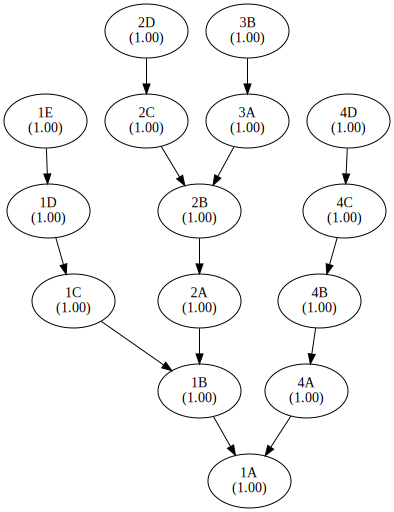

In [5]:
# Catchment of interest
cat_id = "1A"

# Get 'local' data for catchment
print(f"Local attributes for catchment '{cat_id}':")
pp.pprint(g.nodes[cat_id]["local"])

# Plot network
teo.vis.plot_network(g, cat_id, direct="up", stat="local", quant="diff_parx_tonnes")

## 3. Run TEOTIL3

Once the input file is setup correctly, running the model is simple. As long as the correct naming conventions have been followed in the input file, the model will automatically identify the user-specified parameters for accumulation over the network.

In [6]:
# Run model
g = teo.model.run_model(df, id_col="cat_id", next_down_col="next_down_id")

## 4. Explore model output

### 4.1. Network properties

The graph object returned by `run_model()` is identical to that explored above, except an additonal set of attributes has been added to the network nodes (named `accum`). Each node now has two sets of properties:

 1. `local`. These values were already present in the input data (see above) and represent local inputs to each individual catchment, **ignoring any contributions from upstream**

 2. `accum`. These values are the total accumulated fluxes calculated by the model for each catchment outflow i.e. **incorporating everything added locally to the catchment of interest, plus everything from upstream (and allowing for retention)**

In the example below, note the `local` results for `diff_parx_tonnes` and `diff_pary_tonnes` are both 1 (tonne). In contrast, the `accum` results for these parameters are 15 and 1.72 tonnes, respectively. `parx` has a transmission factor of 1, so the total of 15 tonnes simply implies there are 14 catchments upstream of our chosen node (i.e. 15 catchments in total, each receiving 1 tonne of `parx`). This can be illustrated most clearly with a diagram - see below.

Local attributes for catchment '1A':
{'a_cat_land_km2': 1,
 'cat_id': '1A',
 'diff_parx_tonnes': 1,
 'diff_pary_tonnes': 1,
 'next_down_id': '0',
 'q_cat_m3/s': 1,
 'runoff_mm/yr': 400,
 'trans_parx': 1,
 'trans_pary': 0.5}

Accumulated attributes for catchment '1A':
{'diff_parx_tonnes': 15,
 'diff_pary_tonnes': 1.71875,
 'q_m3/s': 15,
 'upstr_area_km2': 15}


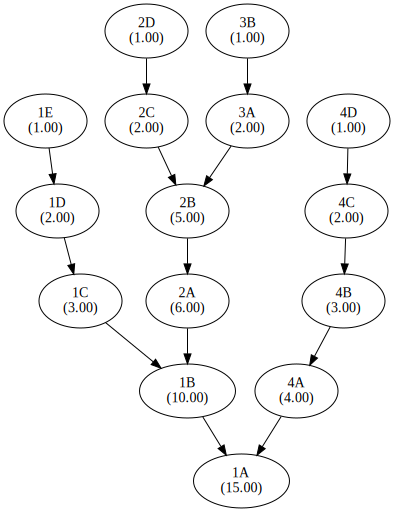

In [7]:
# Get local data for catchment (same as above)
print(f"Local attributes for catchment '{cat_id}':")
pp.pprint(g.nodes[cat_id]["local"])
print("")

# Get accum data for catchment
print(f"Accumulated attributes for catchment '{cat_id}':")
pp.pprint(g.nodes[cat_id]["accum"])

# Plot network
teo.vis.plot_network(g, cat_id, direct="up", stat="accum", quant="diff_parx_tonnes")

The code below shows exactly the same plot, but this time labelled with accumulated fluxes for `pary`, which has a transmission factor of 0.5. Each headwater catchment therefore transmits 0.5 tonnes of `pary` to the next catchment downstream. In the next catchment, a further 1 tonne of `pary` is added, of which 0.75 tonnes are transmitted downstream. The next catchment therefore transmits $0.5∗(1+0.75)=0.88$ tonnes, and so on. The total flux from the final catchment in this case is 1.72 tonnes, compared to 15 tonnes for `parx`. In other words, the vast majority (more than 13 tonnes) of `pary` is retained in the system, even though the retention factors are all set to 0.5. This example illustrates the importance of catchment level retention in correctly determining riverine fluxes.

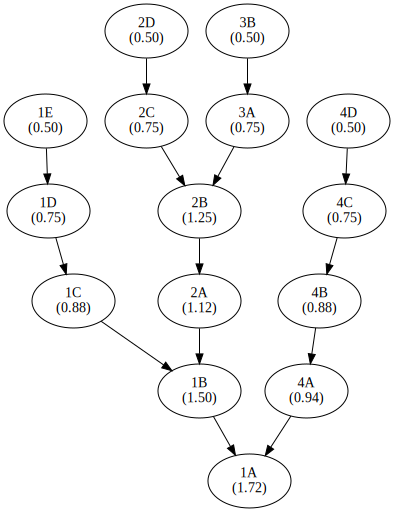

In [8]:
# Plot network
teo.vis.plot_network(g, cat_id, direct="up", stat="accum", quant="diff_pary_tonnes")

### 4.2. Summary maps

TEOTIL3 provides convenient methods for visualising results spatially, as long as you have spatial data for your catchments using the same ID codes as in your adjacency matrix. These functions are not illustrated here since the catchments in this example are fictional, but see Tutorial 2 for a demonstration using real data.

### 4.3. Output table

Model results can be converted to tabular format using `model_to_dataframe`. Optionally, you can also provide a file path to save the results as a CSV e.g. `model_to_dataframe(g, out_path=out_csv)`.

In [9]:
# Convert network to dataframe
res_df = teo.model.model_to_dataframe(g, id_col="cat_id", next_down_col="next_down_id")
res_df

,cat_id,next_down_id,accum_diff_parx_tonnes,accum_diff_pary_tonnes,accum_q_m3/s,accum_upstr_area_km2,local_a_cat_land_km2,local_diff_parx_tonnes,local_diff_pary_tonnes,local_q_cat_m3/s,local_runoff_mm/yr,local_trans_parx,local_trans_pary
0,1E,1D,1,0.50000,1,1,1,1,1,1,400,1,0.5
1,2D,2C,1,0.50000,1,1,1,1,1,1,400,1,0.5
2,3B,3A,1,0.50000,1,1,1,1,1,1,400,1,0.5
3,4D,4C,1,0.50000,1,1,1,1,1,1,400,1,0.5
4,1D,1C,2,0.75000,2,2,1,1,1,1,400,1,0.5
5,2C,2B,2,0.75000,2,2,1,1,1,1,400,1,0.5
6,3A,2B,2,0.75000,2,2,1,1,1,1,400,1,0.5
7,4C,4B,2,0.75000,2,2,1,1,1,1,400,1,0.5
8,1C,1B,3,0.87500,3,3,1,1,1,1,400,1,0.5
9,2B,2A,5,1.25000,5,5,1,1,1,1,400,1,0.5


## 5. Summary

This tutorial used a "toy" dataset to illustrate the basic principles of TEOTIL3, including how the model can be easily extended to simulate any parameter of interest - as long as local inputs and retention factors can be estimated for each catchment in the network. The next tutorial illustrates a more realistic workflow using data from NVE describing Norway's "regine" catchment network.